#  Importing Libraries


In [2]:
import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import pickle
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import LeavePOut
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix, classification_report


2022-12-05 07:47:29.016548: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/saulbarajas/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Importing Dataset

In [4]:
df = pd.read_csv('/Users/saulbarajas/Downloads/training.1600000.processed.noemoticon.csv',
                 encoding = 'latin',header=None)
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


# Analysing the Data

In [5]:
df.shape

(1600000, 6)

In [6]:
df.columns=['sentiments','id','date','query','user','tweet']

In [8]:
df.head()

,sentiments,id,date,query,user,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [9]:
df=df[['sentiments','tweet']]

[Text(0, 0, 'Negative'), Text(1, 0, 'Positive')]

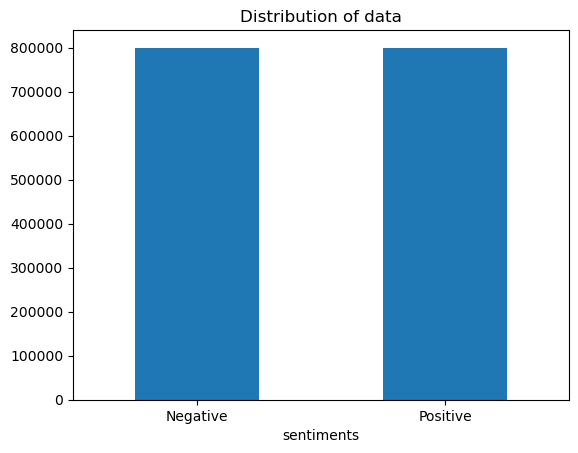

In [10]:
ax = df.groupby('sentiments').count().plot(kind='bar', title='Distribution of data',legend=False)
ax.set_xticklabels(['Negative','Positive'], rotation=0)


# Preprocessing the Data
* Stemming 
* Lematization
* removing Hyperlinks and useraccounts
* removing Stopwords

using NLTK for text processing

In [11]:
stop_words = stopwords.words('english')
stemmer = SnowballStemmer('english')

text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

In [12]:
def preprocess(text, stem=False):
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [13]:
df.tweet = df.tweet.apply(lambda x: preprocess(x))

In [14]:
tweet , sentiments = list(df['tweet']), list(df['sentiments'])

In [15]:
df.head()

,sentiments,tweet
0,0,awww bummer shoulda got david carr third day
1,0,upset update facebook texting might cry result...
2,0,dived many times ball managed save 50 rest go ...
3,0,whole body feels itchy like fire
4,0,behaving mad see


# Hold-out cross-validation

In [16]:
X_train, X_test, y_train, y_test = train_test_split(tweet,sentiments,test_size=0.2,random_state=0)
X_train2, X_test2, y_train2, y_test2 = train_test_split(tweet,sentiments,test_size=0.2,random_state=0)

# TF-IDF, Bag of Words, Word2Vec Vectorizing

In [17]:
def TFIDFVect(X_train,X_test):
    vectoriser = TfidfVectorizer(ngram_range=(1,2),max_features=50000,use_idf=True)
    vectoriser = vectoriser.fit(X_train)
    return vectoriser

In [18]:
def BagWordsVect(X_train,X_test):
    vectoriser = CountVectorizer(ngram_range=(1,2),max_features=50000)
    vectoriser = vectoriser.fit(X_train)
    return vectoriser


In [19]:
vectoriser = TFIDFVect(X_train,X_test)
vectoriser2 = BagWordsVect(X_train2,X_test2)
#vectoriser = Word2Vect(X_train,X_test)
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
X_train2 = vectoriser2.transform(X_train2)
X_test2  = vectoriser2.transform(X_test2)


In [20]:
tfidf_tokens = vectoriser.get_feature_names()
df = pd.DataFrame(data = X_train.toarray(),columns = tfidf_tokens)

In [21]:
bag_tokens = vectoriser2.get_feature_names()
df2 = pd.DataFrame(data = X_train2.toarray(),columns = bag_tokens)

In [48]:
df

,00,00 morning,00 pm,000,000 000,000 contacts,000 followers,000 people,000th,00am,...,zucchini,zumba,zune,zurich,zz,zzz,zzzz,zzzzz,zzzzzz,zzzzzzz
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1279995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.521476,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1279996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1279997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1279998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [22]:
for i,val in enumerate(df.iloc[0]):
    if(val > 0):
        print(df.columns[i])
        print(df.iloc[0][i])
         

like
0.20340002889594863
like ur
0.5109313110721323
pic
0.3315454724883643
thx
0.3723676561344935
ur
0.296256454579847
ur pic
0.5539683148838365
well
0.23312822903533528


In [23]:
for i,val in enumerate(df2.iloc[0]):
    if(val > 0):
        print(df2.columns[i])
        print(df2.iloc[0][i])

like
1
like ur
1
pic
1
thx
1
ur
1
ur pic
1
well
1


# Creating Models

In [24]:
def model_Evaluate(model):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    

In [25]:
def model_EvaluateKFold(model):
    y_pred = cross_val_predict(model, X_test, y_test, cv=10)
    print(classification_report(y_test, y_pred))
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

# Logistic Regression

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


              precision    recall  f1-score   support

           0       0.80      0.77      0.78    159815
           4       0.78      0.81      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



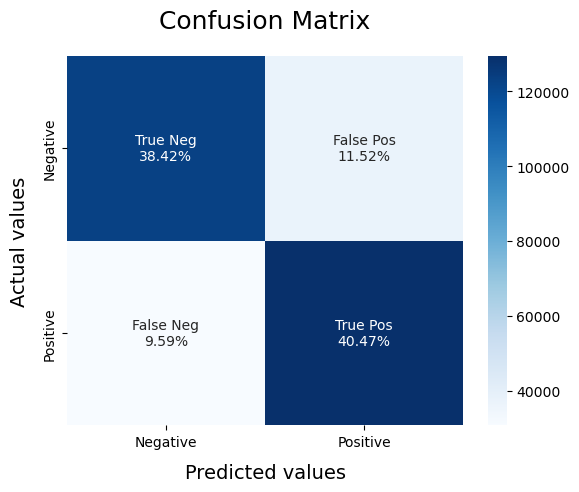

In [26]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


              precision    recall  f1-score   support

           0       0.84      0.63      0.72    159815
           4       0.70      0.88      0.78    160185

    accuracy                           0.75    320000
   macro avg       0.77      0.75      0.75    320000
weighted avg       0.77      0.75      0.75    320000



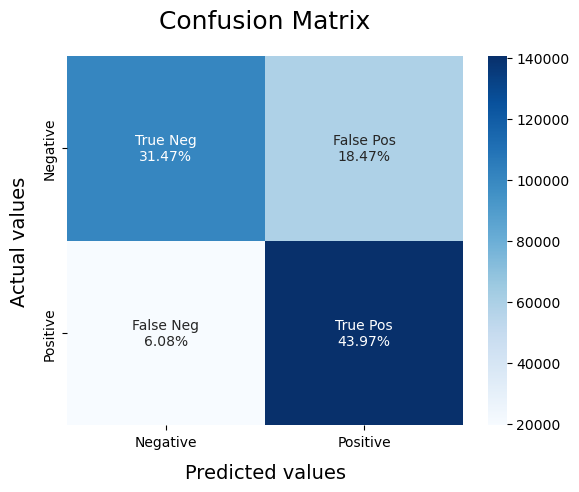

In [27]:
LRmodel2 = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel2.fit(X_train2, y_train2)
model_Evaluate(LRmodel2)

In [37]:
c_range = list(range(1, 7))
c_scores = []
for c in c_range:
    LRmodelKfold = LogisticRegression(C = c, max_iter = 1000, n_jobs=-1,)
    scores = cross_val_score(LRmodelKfold, X_train, y_train, cv=10, scoring='accuracy',)
    c_scores.append(scores.mean())
print(c_scores)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

[0.7883421875, 0.7874148437499999, 0.78662890625, 0.7860468749999999, 0.7856281250000001, 0.78535390625]


Text(0, 0.5, 'Cross-Validated-Accuracy')

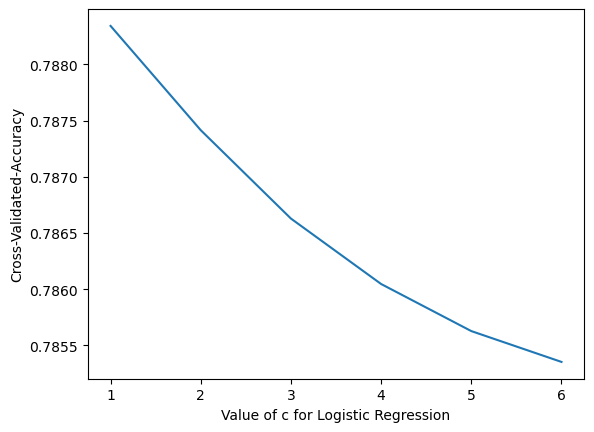

In [38]:
%matplotlib inline
plt.plot(c_range, c_scores)
plt.xlabel('Value of c for Logistic Regression')
plt.ylabel('Cross-Validated-Accuracy')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159815
           4       0.76      0.79      0.77    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



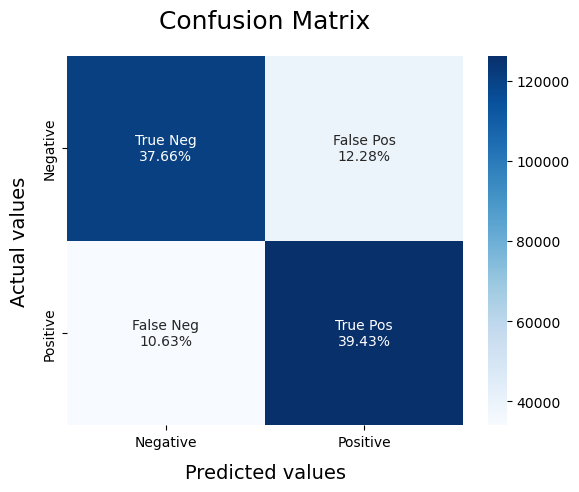

In [45]:
model_EvaluateKFold(LRmodelKfold)

In [46]:
c_range = list(range(1, 7))
c_scores = []
for c in c_range:
    LRmodelKfold2 = LogisticRegression(C = c, max_iter = 1000, n_jobs=-1,)
    scores = cross_val_score(LRmodelKfold2, X_train2, y_train2, cv=4, scoring='accuracy',)
    c_scores.append(scores.mean())
print(c_scores)

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

[0.7836921875, 0.7820578125, 0.7813390625000001, 0.78087421875, 0.7805609375, 0.78034453125]


Text(0, 0.5, 'Cross-Validated-Accuracy')

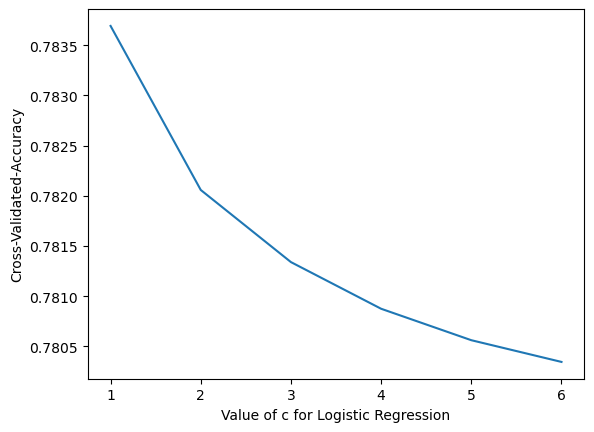

In [47]:
%matplotlib inline
plt.plot(c_range, c_scores)
plt.xlabel('Value of c for Logistic Regression')
plt.ylabel('Cross-Validated-Accuracy')

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:219: RuntimeWarning: scip

              precision    recall  f1-score   support

           0       0.78      0.75      0.77    159815
           4       0.76      0.79      0.77    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



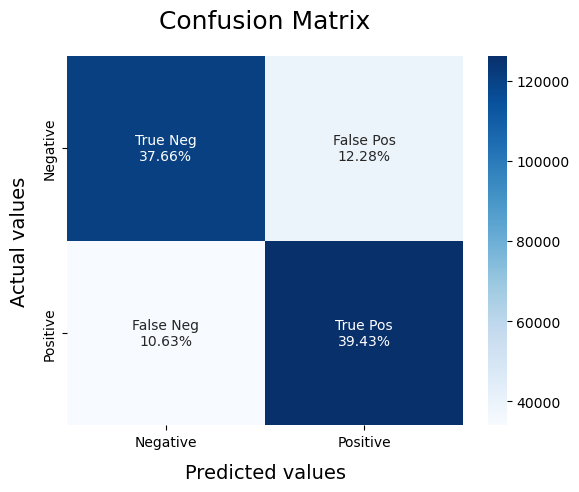

In [48]:
model_EvaluateKFold(LRmodelKfold2)

# Linear Support Vector Classification

              precision    recall  f1-score   support

           0       0.80      0.76      0.78    159815
           4       0.77      0.81      0.79    160185

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



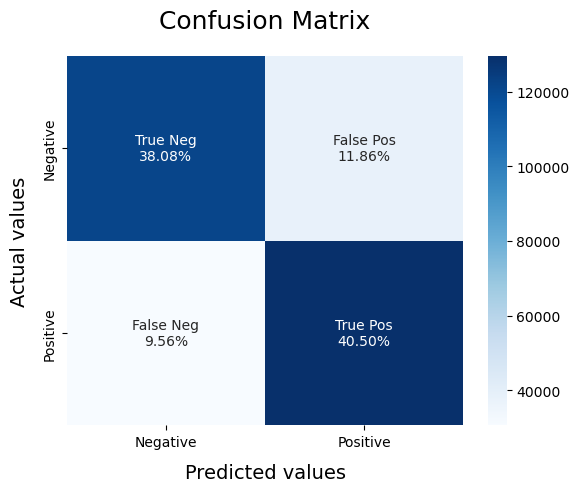

In [28]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)


/Users/saulbarajas/opt/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


              precision    recall  f1-score   support

           0       0.84      0.60      0.70    159815
           4       0.69      0.89      0.78    160185

    accuracy                           0.75    320000
   macro avg       0.77      0.75      0.74    320000
weighted avg       0.77      0.75      0.74    320000



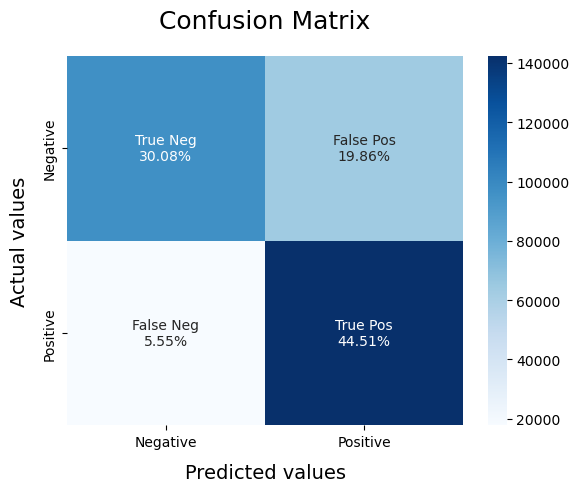

In [29]:
SVCmodel2 = LinearSVC()
SVCmodel2.fit(X_train2, y_train2)
model_Evaluate(SVCmodel2)

In [39]:
c2_range = list(range(1, 7))
c2_scores = []
for c in c2_range:
    SVCmodelKfold = LinearSVC(C=c)
    scores = cross_val_score(SVCmodelKfold, X_train, y_train, cv=10, scoring='accuracy')
    c2_scores.append(scores.mean())
print(c2_scores)

[0.78386953125, 0.7831023437499999, 0.782790625, 0.782625, 0.7825140624999999, 0.7824703125000001]


Text(0, 0.5, 'Cross-Validated-Accuracy')

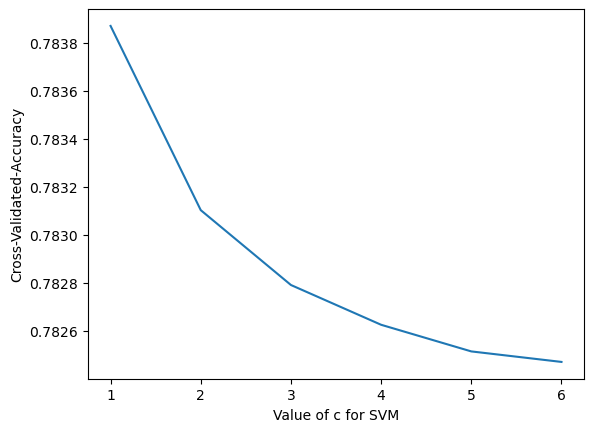

In [40]:
%matplotlib inline
plt.plot(c2_range, c2_scores)
plt.xlabel('Value of c for SVM')
plt.ylabel('Cross-Validated-Accuracy')

              precision    recall  f1-score   support

           0       0.76      0.73      0.75    159815
           4       0.74      0.77      0.76    160185

    accuracy                           0.75    320000
   macro avg       0.75      0.75      0.75    320000
weighted avg       0.75      0.75      0.75    320000



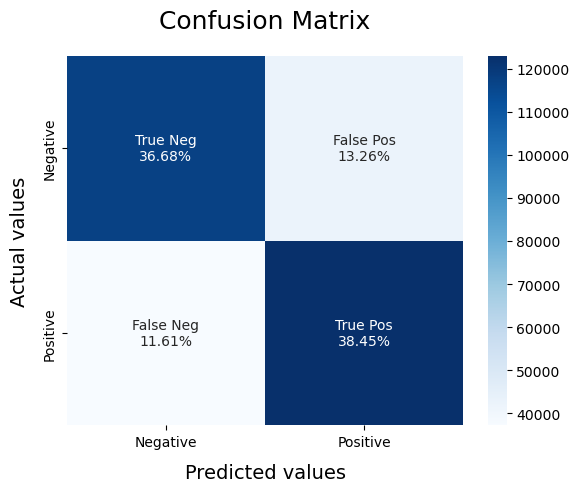

In [44]:
model_EvaluateKFold(SVCmodelKfold)

In [49]:
c2_range = list(range(1, 7))
c2_scores = []
for c in c2_range:
    SVCmodelKfold2 = LinearSVC(C=c)
    scores = cross_val_score(SVCmodelKfold2, X_train2, y_train2, cv=4, scoring='accuracy')
    c2_scores.append(scores.mean())
print(c2_scores)

/Users/saulbarajas/opt/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/saulbarajas/opt/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/saulbarajas/opt/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/saulbarajas/opt/anaconda3/envs/MachineLearning/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increas

KeyboardInterrupt: 

In [ ]:
%matplotlib inline
plt.plot(c2_range, c2_scores)
plt.xlabel('Value of c for SVM')
plt.ylabel('Cross-Validated-Accuracy')

In [ ]:
model_EvaluateKFold(SVCmodelKfold2)

# BernoulliNB

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159815
           4       0.76      0.80      0.78    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



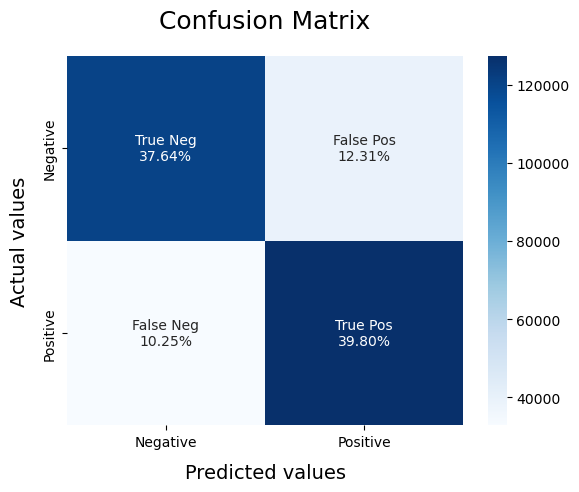

In [32]:
BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

              precision    recall  f1-score   support

           0       0.79      0.75      0.77    159815
           4       0.76      0.80      0.78    160185

    accuracy                           0.77    320000
   macro avg       0.77      0.77      0.77    320000
weighted avg       0.77      0.77      0.77    320000



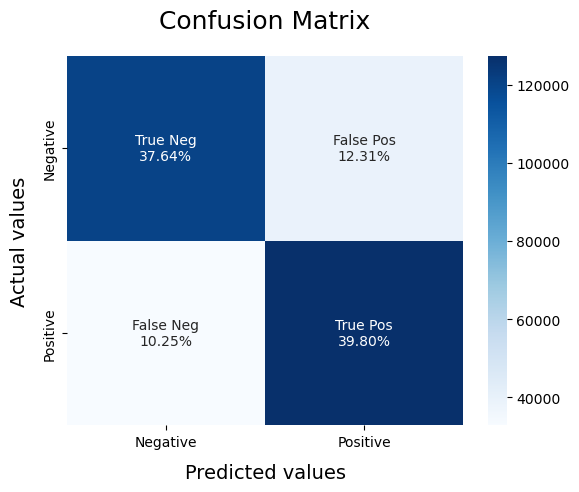

In [33]:
BNBmodel2 = BernoulliNB(alpha = 2)
BNBmodel2.fit(X_train2, y_train2)
model_Evaluate(BNBmodel2)

In [35]:
a_range = list(range(1, 25))
a_scores = []
for a in a_range:
    BNBmodelKFold = BernoulliNB(alpha = a)
    scores = cross_val_score(BNBmodelKFold, X_train, y_train, cv=10, scoring='accuracy')
    a_scores.append(scores.mean())
print(a_scores)

[0.7737265625, 0.77382109375, 0.7738109375, 0.77375625, 0.7737640625, 0.77369375, 0.7736132812500001, 0.77347734375, 0.7733117187499999, 0.7732296875, 0.7731468749999999, 0.7730250000000001, 0.7729, 0.7728140625000001, 0.77267890625, 0.77256796875, 0.77248984375, 0.77241953125, 0.77231015625, 0.7721875, 0.77210859375, 0.7719828125, 0.7718453125, 0.77178515625]


Text(0, 0.5, 'Cross-Validated-Accuracy')

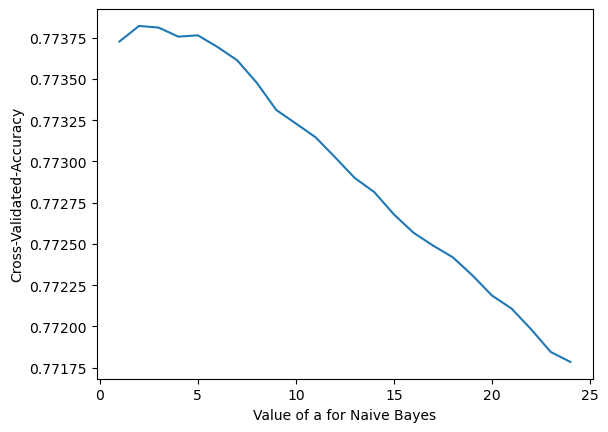

In [36]:
%matplotlib inline
plt.plot(a_range, a_scores)
plt.xlabel('Value of a for Naive Bayes')
plt.ylabel('Cross-Validated-Accuracy')

In [41]:
Y_pred = cross_val_predict(BNBmodelKFold, X_test, y_test, cv=10)
cf_matrix = confusion_matrix(y_test, Y_pred)
cf_matrix



array([[116019,  43796],
       [ 31610, 128575]])

              precision    recall  f1-score   support

           0       0.79      0.73      0.75    159815
           4       0.75      0.80      0.77    160185

    accuracy                           0.76    320000
   macro avg       0.77      0.76      0.76    320000
weighted avg       0.77      0.76      0.76    320000



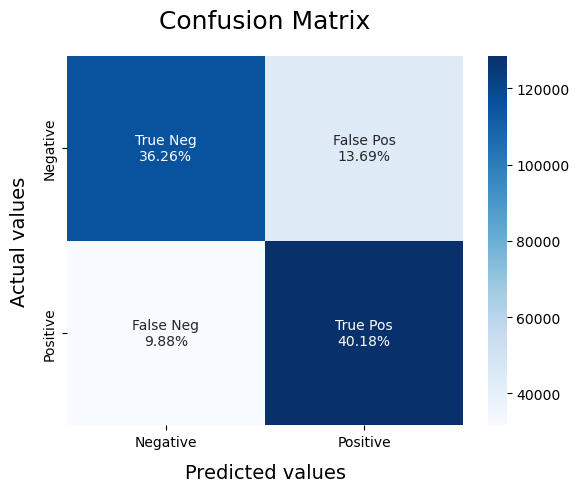

In [42]:
model_EvaluateKFold(BNBmodelKFold)

In [50]:
a_range = list(range(1, 25))
a_scores = []
for a in a_range:
    BNBmodelKFold2 = BernoulliNB(alpha = a)
    scores = cross_val_score(BNBmodelKFold2, X_train2, y_train2, cv=10, scoring='accuracy')
    a_scores.append(scores.mean())
print(a_scores)

[0.7737265625, 0.77382109375, 0.7738109375, 0.77375625, 0.7737640625, 0.77369375, 0.7736132812500001, 0.77347734375, 0.7733117187499999, 0.7732296875, 0.7731468749999999, 0.7730250000000001, 0.7729, 0.7728140625000001, 0.77267890625, 0.77256796875, 0.77248984375, 0.77241953125, 0.77231015625, 0.7721875, 0.77210859375, 0.7719828125, 0.7718453125, 0.77178515625]


Text(0, 0.5, 'Cross-Validated-Accuracy')

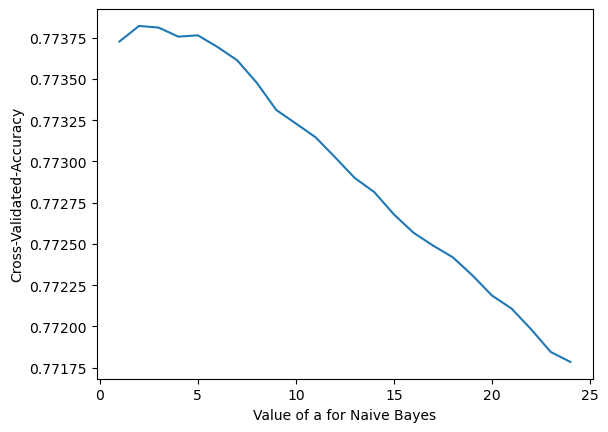

In [51]:
%matplotlib inline
plt.plot(a_range, a_scores)
plt.xlabel('Value of a for Naive Bayes')
plt.ylabel('Cross-Validated-Accuracy')

              precision    recall  f1-score   support

           0       0.79      0.73      0.75    159815
           4       0.75      0.80      0.77    160185

    accuracy                           0.76    320000
   macro avg       0.77      0.76      0.76    320000
weighted avg       0.77      0.76      0.76    320000



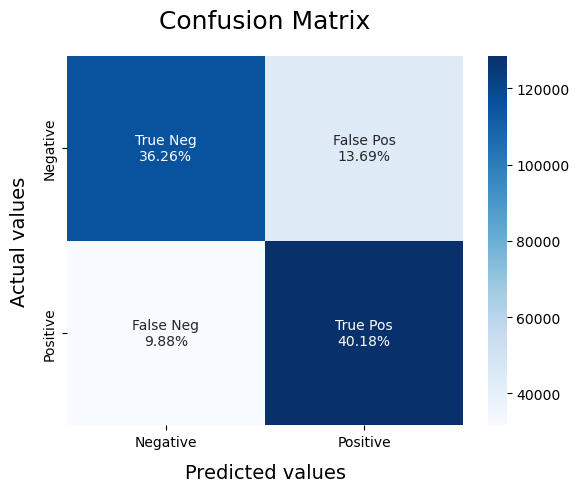

In [54]:
model_EvaluateKFold(BNBmodelKFold2)

# Saving the model and vectorizer files

In [43]:
file = open('vectoriser','wb')
pickle.dump(vectoriser, file)
file.close()
file = open('vectoriser2','wb')
pickle.dump(vectoriser2, file)
file.close()

file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()
file = open('Sentiment-LRBag.pickle','wb')
pickle.dump(LRmodel2, file)
file.close()
file = open('Sentiment-LRKfold.pickle','wb')
pickle.dump(LRmodelKfold, file)
file.close()

file = open('Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()
file = open('Sentiment-SVCBag.pickle','wb')
pickle.dump(SVCmodel2, file)
file.close()
file = open('Sentiment-SVCKfold.pickle','wb')
pickle.dump(SVCmodelKfold, file)
file.close()

file = open('Sentiment-BNB.pickle','wb')
pickle.dump(BNBmodel, file)
file.close()
file = open('Sentiment-BNBBag.pickle','wb')
pickle.dump(BNBmodel2, file)
file.close()
file = open('Sentiment-BNBKfold.pickle','wb')
pickle.dump(BNBmodelKFold, file)
file.close()

In [53]:
file = open('Sentiment-LRKfold2.pickle','wb')
pickle.dump(LRmodelKfold2, file)
file.close()

'''file = open('Sentiment-SVCKfold2.pickle','wb')
pickle.dump(SVCmodelKfold2, file)
file.close()'''

file = open('Sentiment-BNBKfold2.pickle','wb')
pickle.dump(BNBmodelKFold2, file)

# Testing the Models

In [66]:
file = open('./vectoriser', 'rb')
vectoriser = pickle.load(file)
file.close()
file = open('./vectoriser2', 'rb')
vectoriser2 = pickle.load(file)
file.close()

file = open('./Sentiment-LR.pickle', 'rb')
LRmodel = pickle.load(file)
file.close()
file = open('./Sentiment-LRBag.pickle', 'rb')
LRmodel2 = pickle.load(file)
file.close()
file = open('./Sentiment-LRKfold.pickle', 'rb')
LRmodelKfold = pickle.load(file)
file.close()

file = open('./Sentiment-BNB.pickle', 'rb')
BNBmodel = pickle.load(file)
file.close()
file = open('./Sentiment-BNBBag.pickle', 'rb')
BNBmodel2 = pickle.load(file)
file.close()
file = open('./Sentiment-BNBKfold.pickle', 'rb')
BNBmodelKFold = pickle.load(file)
file.close()
 
file = open('./Sentiment-SVC.pickle', 'rb')
SVCmodel = pickle.load(file)
file.close()
file = open('./Sentiment-SVCBag.pickle', 'rb')
SVCmodel2 = pickle.load(file)
file.close()
file = open('./Sentiment-SVCKfold.pickle', 'rb')
SVCmodelKfold = pickle.load(file)
file.close()
    

def predict1(vectoriser, model, tweet):
    textdata = vectoriser.transform(tweet)
    sentiment = model.predict(textdata)
    data = []
    for tweet, pred in zip(tweet, sentiment):
        data.append((tweet,pred))
    df = pd.DataFrame(data, columns = ['tweet','sentiment'])
    df = df.replace([0,4], ["Negative","Positive"])
    return df

def predict2(vectoriser, model, tweet):
    textdata = vectoriser.transform(tweet)
    sentiment = model.predict(textdata)
    data = []
    for tweet, pred in zip(tweet, sentiment):
        data.append((tweet,pred))
    df = pd.DataFrame(data, columns = ['tweet','sentiment'])
    df = df.replace([0,4], ["Negative","Positive"])
    return df

tweet = ["I really love this class ","I love Data ","He passed away at the age 70","Harry is really dumb","I do not like this class"]




In [63]:
print("Logistic Regression \n")
df = predict1(vectoriser, LRmodel, tweet)
print(df.head(), "\n")
print("Logistic Regression Bag\n")
df = predict1(vectoriser2, LRmodel2, tweet)
print(df.head(), "\n")

Logistic Regression 

                          tweet sentiment
0     I really love this class   Positive
1                  I love Data   Positive
2  He passed away at the age 70  Negative
3          Harry is really dumb  Negative
4      I do not like this class  Negative 

Logistic Regression Bag

                          tweet sentiment
0     I really love this class   Positive
1                  I love Data   Positive
2  He passed away at the age 70  Negative
3          Harry is really dumb  Negative
4      I do not like this class  Positive 



In [67]:
print("BNB Model\n")
df = predict1(vectoriser, BNBmodel,tweet)
print(df.head(), "\n")
print("BNB Model Bag\n")
df = predict1(vectoriser2, BNBmodel2,tweet)
print(df.head(), "\n")

BNB Model

                          tweet sentiment
0     I really love this class   Positive
1                  I love Data   Positive
2  He passed away at the age 70  Negative
3          Harry is really dumb  Negative
4      I do not like this class  Negative 

BNB Model Bag

                          tweet sentiment
0     I really love this class   Positive
1                  I love Data   Positive
2  He passed away at the age 70  Negative
3          Harry is really dumb  Negative
4      I do not like this class  Negative 



In [65]:
print("SVC Model \n")
df = predict1(vectoriser, SVCmodel,tweet)
print(df.head(),'\n' )
print("SVC Model Bag \n")
df = predict1(vectoriser2, SVCmodel2,tweet)
print(df.head(),'\n' )

SVC Model 

                          tweet sentiment
0     I really love this class   Positive
1                  I love Data   Positive
2  He passed away at the age 70  Negative
3          Harry is really dumb  Negative
4      I do not like this class  Negative 

SVC Model Bag 

                          tweet sentiment
0     I really love this class   Positive
1                  I love Data   Positive
2  He passed away at the age 70  Negative
3          Harry is really dumb  Negative
4      I do not like this class  Positive 



In [73]:
tweet = ["PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4 ","I was eating food while watching the newest chainsaw man episode and it was not the move", "Leaving Japan today and I’m big sad because it is just amazing here","So many interesting posts on Twitter these days"]
print("Logistic Regression \n")
df = predict1(vectoriser, LRmodel, tweet)
print(df.head(), "\n")
print("Logistic Regression Bag\n")
df = predict1(vectoriser2, LRmodel2, tweet)
print(df.head(), "\n")
print("BNB Model\n")
df = predict1(vectoriser, BNBmodel,tweet)
print(df.head(), "\n")


Logistic Regression 

                                               tweet sentiment
0        PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4   Negative
1  I was eating food while watching the newest ch...  Positive
2  Leaving Japan today and I’m big sad because it...  Negative
3    So many interesting posts on Twitter these days  Positive 

Logistic Regression Bag

                                               tweet sentiment
0        PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4   Negative
1  I was eating food while watching the newest ch...  Positive
2  Leaving Japan today and I’m big sad because it...  Negative
3    So many interesting posts on Twitter these days  Positive 

BNB Model

                                               tweet sentiment
0        PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4   Positive
1  I was eating food while watching the newest ch...  Positive
2  Leaving Japan today and I’m big sad because it...  Negative
3    So many interesting posts on Twitter these days  Po

In [74]:
print("BNB Model Bag\n")
df = predict1(vectoriser2, BNBmodel2,tweet)
print(df.head(), "\n")
print("SVC Model \n")
df = predict1(vectoriser, SVCmodel,tweet)
print(df.head(),'\n' )
print("SVC Model Bag \n")
df = predict1(vectoriser2, SVCmodel2,tweet)
print(df.head(),'\n' )

BNB Model Bag

                                               tweet sentiment
0        PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4   Positive
1  I was eating food while watching the newest ch...  Positive
2  Leaving Japan today and I’m big sad because it...  Negative
3    So many interesting posts on Twitter these days  Positive 

SVC Model 

                                               tweet sentiment
0        PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4   Negative
1  I was eating food while watching the newest ch...  Positive
2  Leaving Japan today and I’m big sad because it...  Negative
3    So many interesting posts on Twitter these days  Positive 

SVC Model Bag 

                                               tweet sentiment
0        PUMP SHOTGUN is BACK IN FORTNITE CHAPTER 4   Negative
1  I was eating food while watching the newest ch...  Positive
2  Leaving Japan today and I’m big sad because it...  Negative
3    So many interesting posts on Twitter these days  Positive 

